In [114]:
from importlib import reload
import flymovie as fm
import cnn_models
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pickle
from pathlib import Path
import scipy.spatial
import scipy.ndimage as ndi
import tensorflow as tf
from importlib import reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Goals

1. Design a test for the performance of an embedding

2. Design a way to apply curriculum learning to my siamese CNN network.


### 1. Designing a test for the performance of an embedding

My strategy is to first construct a test set of images, feed those images through a candidate embedding, and determine the success of the network based on how well similar images are clustered together. Some options:
    - top N accuracy: how often is the most-similar non-self image in the top N
    - Mean ranking of top N: rank images by actual similarity (based on sim parameters), rank them by embedding distance, compare. I think I'll start with just the sum of the squared rank differences. I can probably adapt this to be something with useful statistical properties eventually but no need right now.


In [5]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/variables/checkpoint_0.0001_0.5_nocurriculum'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=18)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

2022-02-18 12:45:44.633327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from cnn_models.siamese_cnn import preprocess_image

############################################################################
def embed_images(im_folder, embedding, mip=False):
    """Pass images from a folder through embedding, return their location 
    and simulation parameters."""
    
    def normalize_params(params):
        std = np.std(params, axis=0)
        # If the parameter is fixed it will have std=0. Since the difference
        # will be 0 and the desired value is all 0, any non-zero value for 
        # std works to avoid divide by 0 error.
        std[std == 0] = 1e6
        p = params.copy()
        p = (p - p.mean(axis=0)) / std
        return p
        
    ims = []
    files = sorted(os.listdir(im_folder))
    num_params = len(files[-1].split('_')) - 2
    params = np.ndarray((0, num_params))

    # Load images and extract parameters.
    for f in files:
        if f[3] != '_':
            continue
        # Because of the silliness with extracting filename from tensor, 
        # have to add two single quotes flanking filename.
        filename = "_'" + os.path.join(im_folder, f) + "'_"
        im = preprocess_image(filename, mip)
        ims.append(im)
        p= f.split('_')[1:-1]
        p = [float(x) for x in p]
        params = np.vstack([params, p])
    
    params = normalize_params(params)

    # Calculate embedding for each image.
    im_embeddings = np.ndarray((0,256))
    for i in range(len(ims)):
        im = ims[i]
        im = np.expand_dims(im, axis=0)
        e = embedding(im).numpy()
        im_embeddings = np.vstack([im_embeddings, e])
        
    return im_embeddings, params

############################################################################
def sort_by_distance(data, n):
        ref = data[n, :]
        f = lambda x: scipy.spatial.distance.euclidean(x, ref)
        dists = np.apply_along_axis(f, 1, data)
        indxs = np.argsort(dists)
        return indxs[1:]

############################################################################
def top_n_accuracy(im_embeddings, params, n):
    if im_embeddings.shape[0] != params.shape[0]:
        raise ValueError('Row number does not match.')
    
    num_images = im_embeddings.shape[0]
    rank_sq_diff_sums = []
    best_in_topn_count = 0

    for i in range(num_images):
        embedding_dist = sort_by_distance(im_embeddings, i)
        param_dist = sort_by_distance(params, i)
        best_idx = param_dist[0]
        if best_idx in embedding_dist[:n]:
            best_in_topn_count += 1
        rank_sq_diff_sum = np.sum((embedding_dist[:n] - param_dist[:n]) ** 2)
        rank_sq_diff_sums.append(rank_sq_diff_sum)
    
    accuracy = best_in_topn_count / num_images
    print('Top ' + str(n) + ' accuracy: ' + str(accuracy))
    rank_sq_diff_mean = np.mean(rank_sq_diff_sums)
    print('Top ' + str(n) + ' rank square difference mean: ' + str(rank_sq_diff_mean))

############################################################################       
def visualize_batch(ds, figsize=4):
    def process_im(arr):
        im = np.squeeze(arr)
        return (im - np.min(im)) / (np.max(im) - np.min(im)) * 1000
    iter = ds.as_numpy_iterator()
    batch = next(iter)
    im1 = process_im(batch[0])
    im2 = process_im(batch[1])
    im3 = process_im(batch[2])
    fm.viewer([im1, im2, im3], figsize)

In [117]:
im_embeddings, params = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/left', embedding)


In [ ]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/variables/checkpoint_0.0001_0.5_all_to_hard'
embedding.load_weights(weights_file)
im_embeddings, params = embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/left', embedding)
params_shuf = params.copy()
np.random.shuffle(params_shuf)

In [ ]:
n=10
np.random.shuffle(params_shuf)
top_n_accuracy(im_embeddings, params, n)
top_n_accuracy(im_embeddings, params_shuf, n)

In [4]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/variables/checkpoint_0.0001_0.5_nocurriculum'
embedding.load_weights(weights_file)
im_embeddings, params = embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/left', embedding)
params_shuf = params.copy()
np.random.shuffle(params_shuf)

NameError: name 'embedding' is not defined

In [ ]:
n=10
np.random.shuffle(params_shuf)
top_n_accuracy(im_embeddings, params, n)
top_n_accuracy(im_embeddings, params_shuf, n)

In [ ]:
# Set up input directories.
from pathlib import Path
folder = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ')
cache_dir=folder
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [ ]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

negative_images = anchor_images + positive_images
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)   

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset)) 
#dataset = dataset.shuffle(buffer_size=1024)

### Below is the new strategy

No longer use shuffling of negative dataset. Start by pairing files (as lists). Will do a scheme where it accepts some parameter (num_negative_pairs maybe) and for each AP pair, generates that many negative pairings that are within some margin in parameter distance. The result will be three ordered lists. Make three datasets from these, zip them, shuffle, and use the take method to select subset.

This way I generate num_images * num_negative_pairs possible APN filename pairings, Randomly sample from those for training sets.

Basically: first generate an excess number of triplets that satisfy margin, randomly sample from those as opposed to doing the shuffling online.

## Goals 2022-02-14

1. Implement the above

2. Comment and test cnn module (ugh). Get it in order.

In [ ]:
a = np.arange(1000)
n = np.arange(2000)
a_dataset = tf.data.Dataset.from_tensor_slices(a)
p_dataset = tf.data.Dataset.from_tensor_slices(a)
n_dataset = tf.data.Dataset.from_tensor_slices(n)

dataset = tf.data.Dataset.zip((a_dataset, p_dataset, n_dataset)) 
dataset = dataset.shuffle(5000)
dataset = dataset.take(1)


In [ ]:
count = 0

for i in dataset:
    print(i)

In [ ]:
iter = dataset.as_numpy_iterator()

def show(ax, image):
        ax.imshow(image, vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(9, 9))

axs = fig.subplots(3, 3)
for i in range(3):
    a = next(iter)
    show(axs[i, 0], a[0].max(axis=0))
    show(axs[i, 1], a[1].max(axis=0))
    show(axs[i, 2], a[2].max(axis=0))

In [ ]:
#cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ')
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_715_ylolCRqp')
left = cache_dir / 'left'
right = cache_dir / 'right'
anchor = sorted(
        [str(left / f) for f in os.listdir(left)]
    )

positive = sorted(
        [str(right / f) for f in os.listdir(right)]
    )


In [ ]:
def fake_files(n):
    l = []
    for _ in range(n):
        f = 'aaa'
        for _1 in range(9):
            f = f + '_' + str(np.random.randint(0,100))
        f = f + '_rep0.pkl'
        l.append(f)
    return l

anchor = fake_files(10_000)
positive = fake_files(10_000)

In [ ]:
rand_indxs = np.random.randint(0,len(a), 3)

def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(9, 9))

axs = fig.subplots(3, 3)
for i in range(3):
    im_a = fm.load_pickle(a[rand_indxs[i]])
    im_p = fm.load_pickle(p[rand_indxs[i]])
    im_n = fm.load_pickle(n[rand_indxs[i]])
    show(axs[i, 0], im_a.max(axis=0))
    show(axs[i, 1], im_p.max(axis=0))
    show(axs[i, 2], im_n.max(axis=0))

    

In [ ]:
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_715_ylolCRqp')
left = cache_dir / 'left'
right = cache_dir / 'right'
anchor = sorted(
        [str(left / f) for f in os.listdir(left)]
    )

positive = sorted(
        [str(right / f) for f in os.listdir(right)]
    )

train, val = cn.make_triplet_inputs(cache_dir, lower_margin=98, upper_margin=100, num_negatives=5)

In [ ]:
visualize_batch(train)

In [ ]:
import tempfile

os.makedir()

In [ ]:
sysTemp = tempfile.gettempdir()
myTemp = os.path.join(sysTemp,'mytemp')

#You must make sure myTemp exists
if not os.path.exists(myTemp):
    os.makedirs(myTemp)


In [ ]:
from flymovie.load_save import save_pickle
from cnn_models.siamese_cnn import make_triplet_inputs

with tempfile.TemporaryDirectory() as topdir:
    print(topdir)
    os.mkdir(os.path.join(topdir, 'left'))
    os.mkdir(os.path.join(topdir, 'right'))

    im = np.ones((10,20,20))
    im1 = im.copy()
    im1[0,0,0] = 10
    im2 = im.copy()
    im2[0,0,1] = 10
    save_pickle(im1, os.path.join(topdir, 'left', 'aaa_10_10_10_10_10_10_10_10_10_rep0.pkl'))
    save_pickle(im1, os.path.join(topdir, 'right', 'aaa_10_10_10_10_10_10_10_10_10_rep1.pkl'))
    save_pickle(im1, os.path.join(topdir, 'left', 'bbb_9_9_9_9_9_9_9_9_9_rep0.pkl'))
    save_pickle(im1, os.path.join(topdir, 'right', 'bbb_9_9_9_9_9_9_9_9_9_rep1.pkl'))
    save_pickle(im2, os.path.join(topdir, 'left', 'ccc_1_1_1_1_1_1_1_1_1_rep0.pkl'))
    save_pickle(im2, os.path.join(topdir, 'right', 'ccc_1_1_1_1_1_1_1_1_1_rep1.pkl'))
    save_pickle(im2, os.path.join(topdir, 'left', 'ddd_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_rep0.pkl'))
    save_pickle(im2, os.path.join(topdir, 'right', 'ddd_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_rep1.pkl'))
    cache_dir = Path(topdir)
    train_dataset, val_dataset = make_triplet_inputs(cache_dir, lower_margin=0, upper_margin=45, num_negatives=1, 
        n_repeats=1, mip=False, batch_size=1, rotate=False)
    for batch in train_dataset:
        print('batch')

    for batch in val_dataset:
        print('v')
    
    for batch in train_dataset:
        print(batch[0][0,0,0,0,0])
        print(batch[2][0,0,0,0,0])
        print('')

    for batch in val_dataset:
        print(batch[0][0,0,0,0,0])
        print(batch[2][0,0,0,0,0])
        print('')
    """
    for batch in val_dataset:
        print(batch[0][0,0,0,1,0])
        print(batch[1][0,0,0,1,0])
        print(batch[2][0,0,0,1,0])
        print('')
    """
    #visualize_batch(train_dataset)


In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  #if epoch < 10:
  #  return lr
  #else:
    return lr * 0.9#tf.math.exp(-0.1)

model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
round(model.optimizer.lr.numpy(), 5)


In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=1, callbacks=[callback], verbose=0)
round(model.optimizer.lr.numpy(), 5)


In [ ]:
anchor_files = ['abc', 'def']
ds = tf.data.Dataset.from_tensor_slices(anchor_files)
def f(x):
    print(x)
    fm.load_pickle(x)
    return x
def process(x):
    
    x = tf.py_function(f, [x,], [tf.string,])
    return x
_ = ds.map(process)

In [ ]:
h = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch_histories/history_0.001_0.5_all_to_hard.pkl')

In [ ]:
def plot_history(h):
    val_loss = []
    loss = []
    lr = []
    for i in range(len(h)):
        val_loss = val_loss + h[i]['val_loss']
        loss = loss + h[i]['loss']
        lr = lr + h[i]['lr']

    plt.plot(val_loss)
    #plt.plot(np.arange(1, len(loss)), loss[1:])
    #plt.plot(np.arange(0, len(lr)),lr * 100)

plot_history(h)

In [ ]:
h = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch_histories/history_0.001_0.5_all_to_hard.pkl')
plot_history(h)
h = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch_histories/history_0.00033_0.5_all_to_hard.pkl')
plot_history(h)
h = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch_histories/history_0.0001_0.5_all_to_hard.pkl')
plot_history(h)


In [ ]:
h = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch_histories/history_0.0001_0.5_nocurriculum.pkl')
plot_history(h)
h = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch_histories/history_0.0001_0.5_all_to_hard.pkl')
plot_history(h)

In [40]:
def compare_embeddings_self(embeddings1, embeddings2):
    ranks = []
    for n in range(embeddings1.shape[0]):
        emb_ref = embeddings1[n]
        embeddings_nonself = np.vstack((embeddings2, embeddings1[:n, :], embeddings1[(1+n):, :]))
        dists = np.sum((embeddings_nonself - emb_ref) ** 2, axis=1)
        idxs_sorted = np.argsort(dists)
        ranks.append(np.where(idxs_sorted == n)[0][0])
        
    return ranks


compare_embeddings_self(im_embeddings1, im_embeddings2)

[0.62194413 0.30649454 0.04895138]


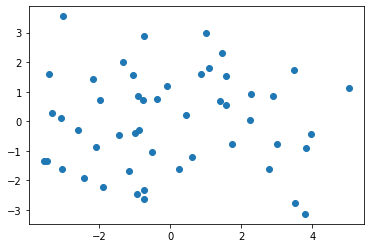

In [54]:
from sklearn.decomposition import PCA

X = im_embeddings1.copy()
pca = PCA(n_components=3)
pca.fit(X)
print(pca.explained_variance_ratio_)
for e in (embedd)
plt.scatter(components[:,0], components[:,1])


In [56]:
pca.transform

<bound method _BasePCA.transform of PCA(n_components=3)>

In [120]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/variables/checkpoint_0.001_0.5_nocurriculum'
embedding.load_weights(weights_file)
im_embeddings1, params1 = embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/left', embedding)
im_embeddings2, params2 = embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/right', embedding)
#compare_embeddings_self(im_embeddings1, im_embeddings2)

In [121]:
compare_embeddings_matchedpairs(im_embeddings1, im_embeddings2)



array([0. , 0. , 0. , 0. , 1.5, 0. , 0.5, 0. , 0. , 0. , 0.5, 0. , 1.5,
       0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0.5, 1. ,
       0. , 1. , 0. , 0.5, 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0.5])

In [123]:
np.random.shuffle(im_embeddings2)
compare_embeddings_matchedpairs(im_embeddings1, im_embeddings2)

array([ 3.5, 22.5,  7.5,  8. ,  6.5, 16. , 41.5, 45.5, 46.5, 37.5, 18. ,
       14.5, 47. , 18.5,  8. , 31. , 16.5, 26.5, 44.5,  0.5,  6. , 41.5,
        5. , 42. , 39.5, 46.5, 30. , 15. , 49. , 20.5, 24. , 13. ,  8.5,
       47. , 16.5, 40. , 34.5, 10. , 27. , 14. ,  0.5,  7.5, 44.5,  8. ,
       16.5, 32. ,  0.5,  5.5, 20.5, 39.5])

I need some new ideas on how to test these. I think the magic is going to be in the test datasets. Some ideas:
    - Take real images, transform, test:
        - multiple simulations of same parameters
        - rotation
        - re-apply noise
    - Simulate images with narrow or wide ranges of parameters matched to 
    - Simulate images that vary only in certain traits and see how well separated they are.


Two sides to every test: the similar images and the competition. Accuracy will depend on both. Want to challenge our network with 

I think this ends up with generating a bunch of sets which consist of paired images. The pairs are similar images. The task for each is to determine the ranking of the distance between the pairs compared to the distance to all others in the set. Can then do topN accuracy or mean rank.

Write a function to print out a report for a model.

Test function:
    - Get embedding for left and right
    - Stack all of left except self onto right files
    - calc distance to ref in embedding
    - Rank
    - return rank of "self"


In [119]:
compare_embeddings_matchedpairs(im_embedding)

NameError: name 'im_embedding' is not defined

[0.61601948 0.3155334  0.04522466]


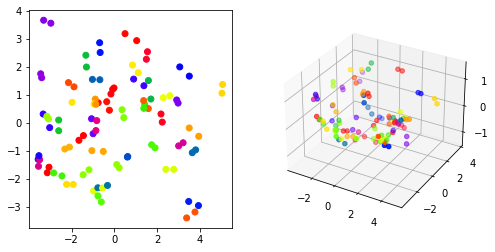

In [118]:
#---------------------------------------------------------------------------
def rank_embeddingdist_matchedpairs(embeddings1, embeddings2):
    """Determine the ranking of matched pairs of images w.r.t. embedding 
    distance.
    
    Takes two sets of embeddings that represent matched pairs of images 
    (the same row in embeddings1 and embeddings2 correspond to paired images,
    e.g. two different simulations performed with the same parameters). For
    each image, the distance to every other image is calculated, the 
    distances are ranked, and the ranking of its matched pair is recorded. 
    For an ideal model, the ranking will always be 0. 
    
    
    """
    def get_ranks(embeddins1, embeddings2):
        ranks = []
        for n in range(embeddings1.shape[0]):
            emb_ref = embeddings1[n]
            # Stack all the embeddings EXCEPT self from first set onto second
            # set. The row number of the matched pair will be unchanged.
            embeddings_nonself = np.vstack((embeddings2, embeddings1[:n, :], 
                                embeddings1[(1+n):, :]))
            dists = np.sum((embeddings_nonself - emb_ref) ** 2, axis=1)
            # Rank indexes by distance, add the rank of the matched pair.
            idxs_sorted = np.argsort(dists)
            ranks.append(np.where(idxs_sorted == n)[0][0])
            
        return np.array(ranks)
    
    # Get the ranks wrt each image in embeddings1, then embeddings2, return mean 
    # rank for each pair.
    ranks1 = get_ranks(embeddings1, embeddings2)
    ranks2 = get_ranks(embeddings2, embeddings1)
    return (ranks1 + ranks2) / 2


def plot_pca(embeddings1, embeddings2):
    combined = np.vstack((embeddings1, embeddings2))
    pca = PCA(n_components=3)
    pca.fit(combined)
    print(pca.explained_variance_ratio_)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    for e in (embeddings1, embeddings2):
        tfm = pca.transform(e)
        ax1.scatter(tfm[:,0], tfm[:,1], c = np.arange(tfm.shape[0]), cmap='prism')
        ax2.scatter(tfm[:,0], tfm[:,1], tfm[:,2], c = np.arange(tfm.shape[0]), cmap='prism')

plot_pca(im_embeddings1, im_embeddings2)

[0.61601948 0.3155334  0.04522466]


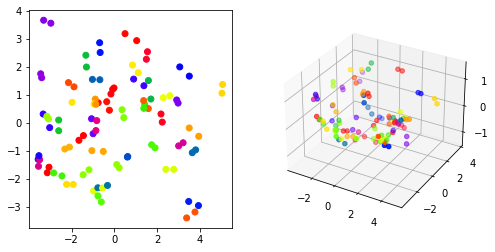

In [113]:
import tempfile
def test_pdf(embeddings1, embeddings2):
    ranks = compare_embeddings_self(embeddings1, embeddings2)
    plot_pca(embeddings1, embeddings2)
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)
    pdf.cell(40, 10, 'Hello World!')
    #plt.scatter(np.random.random(10), np.random.random(10))
    with tempfile.NamedTemporaryFile('w', suffix='.png') as f:
        plt.savefig(f.name, dpi=150)
        pdf.image(f.name, w=65, h=50)
    pdf.output('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/test.pdf', 'F')
        
        
test_pdf(im_embeddings1, im_embeddings2)